# Initial Exploratory Data Analysis

In [16]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import json
from labeling_schema import LABELS
from openai import OpenAI
from dotenv import load_dotenv
import base64

In [2]:
DATA_DIR = "../sampled_images/2024-03-25-15-40-16"

image_files = []
for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            image_files.append(os.path.join(root, file))

print(f"Found {len(image_files)} images.")

Found 5 images.


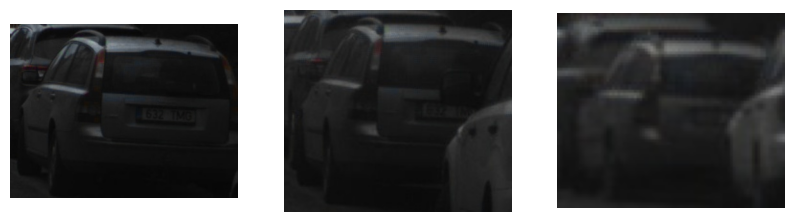

In [3]:
sample_files = random.sample(image_files, 3)

plt.figure(figsize=(10, 10))
for i, file in enumerate(sample_files):
    img = Image.open(file)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [4]:
widths, heights = [], []
for file in image_files:
    img = Image.open(file)
    widths.append(img.width)
    heights.append(img.height)

print(f"Image sizes: min={min(widths)}x{min(heights)}, max={max(widths)}x{max(heights)}, mean={int(np.mean(widths))}x{int(np.mean(heights))}")

Image sizes: min=83x71, max=355x275, mean=182x181


## Labeling Schema

- Left turn signal (on/off)
- Right turn signal (on/off)
- Hazard lights
- Tail lights (presence/absence)
- No visible lights

(Added no visible lights because of the above sample with all lights obscured by front vehicle)

In [19]:
print("Labeling schema defined:", LABELS)

Labeling schema defined: {0: 'left_turn', 1: 'right_turn', 2: 'hazard', 3: 'no_visible_light', 4: 'tail_light_on'}


# YOLO (only dummy classifier so far)

So right now it's just picking a random annotation

In [20]:
OUTPUT_ANNOTATIONS = "annotations.json"

In [21]:
def dummy_classifier(image_path):
    """
    Simulates classification by randomly deciding which lights are on.
    Later, this will be replaced by a real model.
    """
    labels_on = [LABELS[key] for key in LABELS if random.random() > 0.7]
    return labels_on

In [22]:
annotations = []
for img in image_files:
    labels = dummy_classifier(img)
    annotations.append({
        "image": img,
        "labels": labels
    })

In [23]:
with open(OUTPUT_ANNOTATIONS, "w") as f:
    json.dump(annotations, f, indent=2)

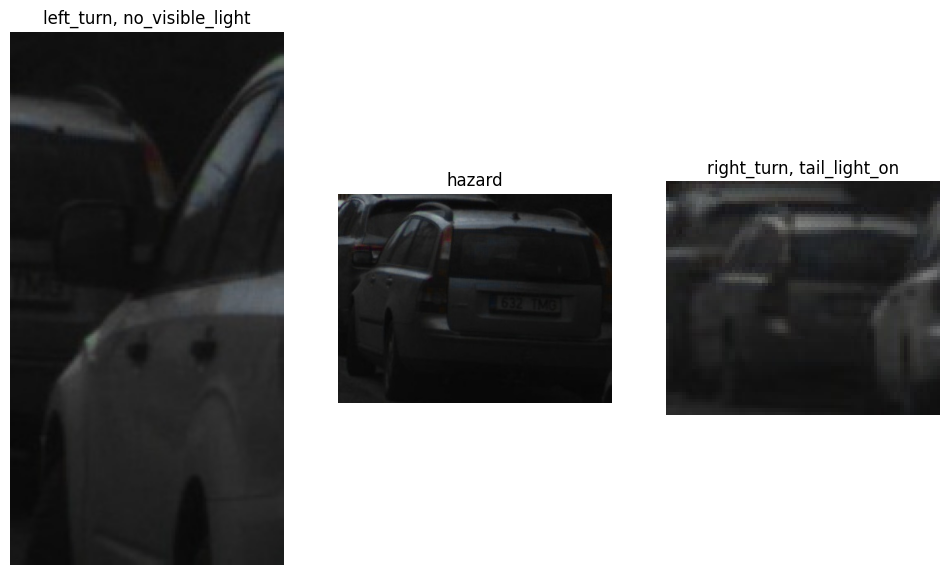

In [24]:
sample_annotations = random.sample(annotations, 3)

plt.figure(figsize=(12, 8))
for i, ann in enumerate(sample_annotations):
    img = Image.open(ann["image"])
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(", ".join(ann["labels"]) if ann["labels"] else "No lights on")
    plt.axis('off')
plt.show()

# OpenAPI Classifier

In [26]:
load_dotenv() 
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [27]:
OUTPUT_FILE = "annotations_openai.json"

def encode_image(image_path):
    with open(image_path, "rb") as img:
        return base64.b64encode(img.read()).decode("utf-8")

In [48]:
def classify_image(image_path):
    img_b64 = encode_image(image_path)
    prompt = """
    Look at this car image and determine which lights are on.
    Possible labels: "left_turn", "right_turn", "hazard", "no_visible_light", "tail_light_on".
    Return valid JSON **exactly** like this example:

    {
      "labels": ["left_turn", "brake"]
    }

    If no lights are on, return an empty array for "labels".
    """
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_b64}"}}
                ]
            }
        ],
        temperature=0
    )

    raw = response.choices[0].message.content
    if raw.startswith("```json") and raw.endswith("```"): # Theres some type of issue with markdown backticks being added
        raw = raw[7:-3].strip()

    try:
        return json.loads(raw)["labels"]
    except (json.JSONDecodeError, KeyError):
        print(f"Failed to parse response for {image_path}: {raw}")
        return []

In [49]:
annotations = []
for img in image_files:
    labels = classify_image(img)
    annotations.append({"image": img, "labels": labels})

with open(OUTPUT_FILE, "w") as f:
    json.dump(annotations, f, indent=2)

print(f"Saved {len(annotations)} annotations to {OUTPUT_FILE}")

Saved 5 annotations to annotations_openai.json


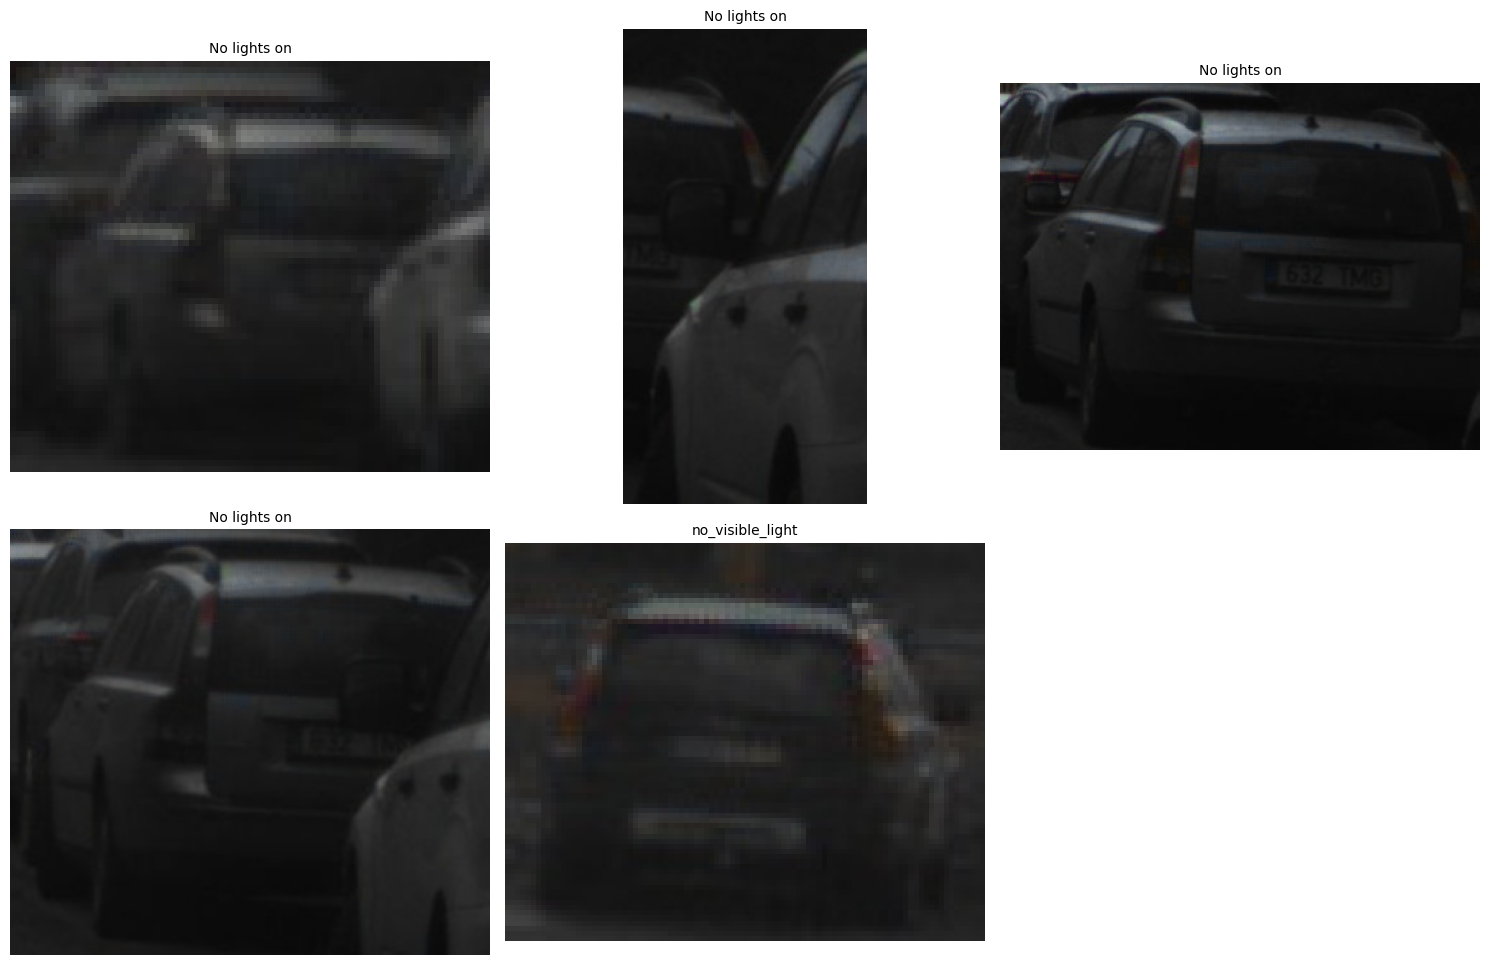

In [50]:
sample_annotations = random.sample(annotations, 5)

plt.figure(figsize=(15, 10))

for i, ann in enumerate(sample_annotations):
    try:
        img = Image.open(ann["image"])

        plt.subplot(2, 3, i + 1) 
        plt.imshow(img)

        # Get the labels, or "No lights on" if the list is empty
        labels = ann.get("labels", []) 
        label_text = ", ".join(labels) if labels else "No lights on"

        plt.title(label_text, fontsize=10)

        plt.axis('off')

    except FileNotFoundError:
        print(f"Image not found: {ann['image']}")
        continue

plt.tight_layout()
plt.show()